# Module 13 - Programming Assignment

## Directions

There are general instructions on Blackboard and in the Syllabus for Programming Assignments. This Notebook also has instructions specific to this assignment. Read all the instructions carefully and make sure you understand them. Please ask questions on the discussion boards or email me at `EN605.445@gmail.com` if you do not understand something.

<div style="background: mistyrose; color: firebrick; border: 2px solid darkred; padding: 5px; margin: 10px;">
You must follow the directions *exactly* or you will get a 0 on the assignment.
</div>

You must submit a zip file of your assignment and associated files (if there are any) to Blackboard. The zip file will be named after you JHED ID: `<jhed_id>.zip`. It will not include any other information. Inside this zip file should be the following directory structure:

```
<jhed_id>
    |
    +--module-01-programming.ipynb
    +--module-01-programming.html
    +--(any other files)
```

For example, do not name  your directory `programming_assignment_01` and do not name your directory `smith122_pr1` or any else. It must be only your JHED ID. Make sure you submit both an .ipynb and .html version of your *completed* notebook. You can generate the HTML version using:

> ipython nbconvert [notebookname].ipynb

or use the File menu.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## k Nearest Neighbors and Model Evaluation

You must complete the 4 following tasks:

1. Implement k-Nearest Neighbor *regression* as described in the Module.
2. Use validation curves as described in Module 9 to determine the best value of k trying values of 1 to 10. (You don't need to use odd values for regression). For this you can simply split the data randomly into a training and a test set with a 67/33 split.
3. Use learning curves as described in Module 9 to determine if your model could use more data.
    For this you can simply split the data randomly into a training and a test set with a 67/33 split. Use the best k from part 2.
4. Use 10-fold cross-validation to establish confidence bounds on your model's performance. Calculate the mean (average) MSE (which sounds funny, I know) and the standard deviation. 

Additionally, because you can't be *wrong* with the k = 1 in the training data, your curves will look a little funky initially.

As before make sure you actually plot curves and that everything is labeled. Each chart from part #2 and #3 has *two* curves. Please review the comments to Module 9 if you're not sure why.

Use the data in concrete_compressive_strength.csv for this assignment obtainable at [UCI ML Repository - Concrete Compressive Strength](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength).

Because the data is always the model, for knn, you simply need a function `knn` that will take the data, a value for k, and a List of instances and return a List of predictions (in this case, we're doing regression...you don't have to write a version of `knn` that would do either).

As before there's a lot of infrastructure involved and the specific names I leave up to you as long as you clearly indicate your answers to 1-4 above.

-----

In [2]:
def randomizedSplit(d, classVar, pct):
    cols = [v for v in d.dtype.names if v != classVar] + [classVar]
    d = d[cols]
    d = np.array(d.tolist())

    idx = range(d.shape[0])
    np.random.shuffle(idx)
    split = int(np.floor(d.shape[0] * pct))
    return d[:split], d[split:]

def standardize(inD, classVar):
    d = np.copy(inD)
    for v in d.dtype.names:
        if v == classVar: # do not standardize class variable
            continue
        d[v] = (d[v] - np.mean(d[v])) / np.std(d[v])

    return d

def plotRMSE(hyperParm, data, labels=('','')):
    plt.plot(hyperParm, data, label='RMSE')
    plt.legend(loc=0)
    plt.axis([0, max(hyperParm), -0, 20])
    plt.ylabel(labels[1])
    plt.xlabel(labels[0])
    plt.show()
    return

In [3]:
raw = np.recfromcsv('Concrete_Data.csv', delimiter=',')
data = standardize(raw, 'strength')
(train, test) = randomizedSplit(data, 'strength', 0.67)

In [4]:
def D(r1, r2):
    return np.sqrt(np.sum((r1-r2)**2, axis=1))

def KNN(data, toClass, k, majority=False):
    pred = np.zeros(toClass.shape[0])
    
    for n,t in enumerate(toClass):
        dist = D(t[:-1], data[:,:-1])
        kInd = np.argpartition(dist, k)[:k]
        knn, kDist = data[:,-1][kInd], dist[kInd]
        
        if not majority:
            pred[n] = np.average(knn, weights=1/(1e-9 + kDist) )
        else:
            k, kN = np.unique(knn, return_counts=True)
            maxInd = np.argwhere(kN==np.amax(kN))
            if len(maxInd) > 1:
                maxInd = np.random.choice(maxInd, 1)
            pred[n] = k[maxInd]

    return pred, np.linalg.norm(pred-toClass[:,-1])/np.sqrt(pred.size)

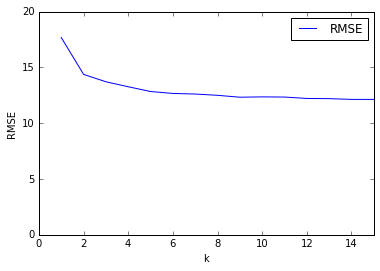

In [5]:
kList = range(1,16)
rmseVal = np.array([KNN(train,test, k)[1] for k in kList])
plotRMSE(kList, rmseVal, ('k','RMSE'))

While the RMSE is non-increasing wrt k, the marginal improvement is insignificant where k>7. Therefore k=7 is the best hyperparameter.

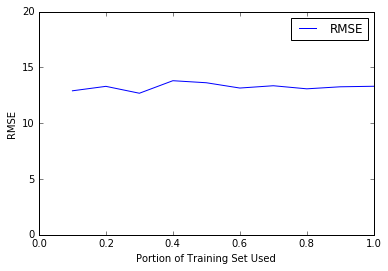

In [6]:
kOpt = 7
dsetSize = (np.arange(10)+1.0)/10
rmseLearn = np.zeros(len(dsetSize))
for n,s in enumerate(dsetSize):
    idx = np.random.choice(train.shape[0], int(s*train.shape[0]) )
    _, rmseLearn[n] = KNN(train[idx,:], test, kOpt)
    
plotRMSE(dsetSize, rmseLearn, ('Portion of Training Set Used','RMSE'))

In [7]:
slices = 10
whole = np.array(data.tolist())
rmseCross = np.zeros(len(dsetSize))
idx = np.arange(whole.shape[0])
np.random.shuffle(idx)
chunks = np.array_split(idx, slices)

for n in range(slices):
    selected = np.hstack([chunks[x] for x in range(slices) if x != n])
    nonselect = np.hstack([chunks[x] for x in range(slices) if x == n])
    _, rmseCross[n] = KNN(whole[selected,:], whole[nonselect,:], kOpt)

print('Average RMSE is %f.'%np.mean(rmseCross))
print('Std Dev of RMSE is %f.'%np.std(rmseCross))

Average RMSE is 13.285392.
Std Dev of RMSE is 0.973718.
